<a href="https://colab.research.google.com/github/rahiakela/data-science-research-and-practice/blob/main/think-stats/03_cumulative_distribution_functions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Setup

In [1]:
import numpy as np
from os.path import basename, exists

In [2]:
def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve

        local, _ = urlretrieve(url, filename)
        print("Downloaded " + local)

In [3]:
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/thinkstats2.py")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/thinkplot.py")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/nsfg.py")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/first.py")

download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/2002FemPreg.dct")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/2002FemPreg.dat.gz")

Downloaded thinkstats2.py
Downloaded thinkplot.py
Downloaded nsfg.py
Downloaded first.py
Downloaded 2002FemPreg.dct
Downloaded 2002FemPreg.dat.gz


In [4]:
from collections import Counter

import numpy as np
import pandas as pd

import nsfg
import first
import thinkstats2
import thinkplot

##Limits of PMFs

In [5]:
# One more time, I'll load the data from the NSFG.
live, firsts, others = first.MakeFrames()

In [6]:
# And compute the distribution of birth weight for first babies and others
first_wgt = firsts.totalwgt_lb
first_wgt_dropna = first_wgt.dropna()
print(f"Firsts {len(first_wgt)}, {len(first_wgt_dropna)}")

other_wgt  = others.totalwgt_lb
other_wgt_dropna  = other_wgt .dropna()
print(f"Others {len(other_wgt)}, {len(other_wgt_dropna )}")

first_pmf = thinkstats2.Pmf(first_wgt_dropna, label='first')
other_pmf = thinkstats2.Pmf(other_wgt_dropna, label='other')

Firsts 4413, 4363
Others 4735, 4675


We can plot the PMFs on the same scale, but it is hard to see if there is a difference.

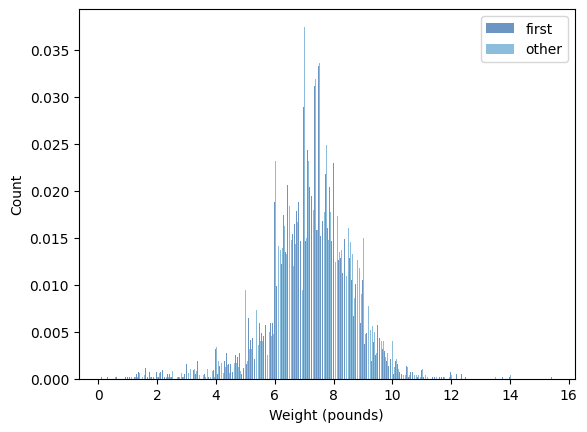

In [7]:
width = .4 / 16

# plot PMFs of birth weights for first babies and others
thinkplot.PrePlot(2)
thinkplot.Hist(first_pmf, align="right", width=width)
thinkplot.Hist(other_pmf, align="left", width=width)
thinkplot.Config(xlabel="Weight (pounds)", ylabel="Count")

##Percentiles

Percentile Rank computes the fraction of scores less than or equal to `your_score`.

In [8]:
def percentile_rank(scores, your_score):
    count = 0
    for score in scores:
        if score <= your_score:
            count += 1

    percentile_rank = 100.0 * count / len(scores)
    return percentile_rank

In [9]:
# If this is the list of scores.
t = [55, 66, 77, 88, 99]

In [10]:
# If you got the 88, your percentile rank is 80.
percentile_rank(t, 88)

80.0

In [11]:
def percentile(scores, p_rank):
    scores.sort()
    for score in scores:
        if percentile_rank(scores, score) >= p_rank:
            return score

In [12]:
# The median is the 50th percentile, which is 77.
percentile(t, 50)

77

Here's a more efficient way to compute percentiles.

In [13]:
def percentile2(scores, p_rank):
    scores.sort()
    index = p_rank * (len(scores)-1) // 100
    return scores[int(index)]

In [14]:
# Let's hope we get the same answer.
percentile2(t, 50)

77

##CDF

The Cumulative Distribution Function (CDF) is almost the same as `PercentileRank`. The only difference is that the result is `0-1` instead of `0-100`.

In [15]:
def eval_cdf(sample, x):
    count = 0.0
    for value in sample:
        if value <= x:
            count += 1
    prob = count / len(sample)
    return prob

In [16]:
t = [1, 2, 2, 3, 5]

In [17]:
# We can evaluate the CDF for various values
eval_cdf(t, 0), eval_cdf(t, 1), eval_cdf(t, 2), eval_cdf(t, 3), eval_cdf(t, 4), eval_cdf(t, 5)

(0.0, 0.2, 0.6, 0.8, 0.8, 1.0)

Here's an example using real data, the distribution of pregnancy length for live births.

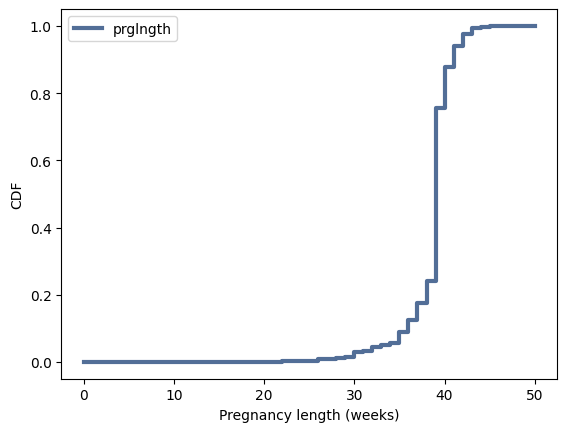

In [18]:
cdf = thinkstats2.Cdf(live.prglngth, label="prglngth")
thinkplot.Cdf(cdf)
thinkplot.Config(xlabel="Pregnancy length (weeks)", ylabel="CDF", loc="upper left")

`Cdf` provides `Prob`, which evaluates the CDF; that is, it computes the fraction of values less than or equal to the given value.

For example, 94% of pregnancy lengths are less than or equal to 41.

In [19]:
cdf.Prob(41)

0.9406427634455619

In [20]:
cdf.Prob(40)

0.8764757324005247

In [21]:
cdf.Prob(39)

0.7544818539571491

In [22]:
cdf.Prob(38)

0.2414735461303017

`Value` evaluates the inverse CDF; given a fraction, it computes the corresponding value.

For example, the median is the value that corresponds to 0.5.

In [23]:
cdf.Value(0.94)

41

In [24]:
cdf.Value(0.87)

40

In [25]:
cdf.Value(0.75)

39

In [26]:
cdf.Value(0.24)

38

##Comparing CDFs

In general, CDFs are a good way to visualize distributions. They are not as noisy as PMFs, and if you plot several CDFs on the same axes, any differences between them are apparent.

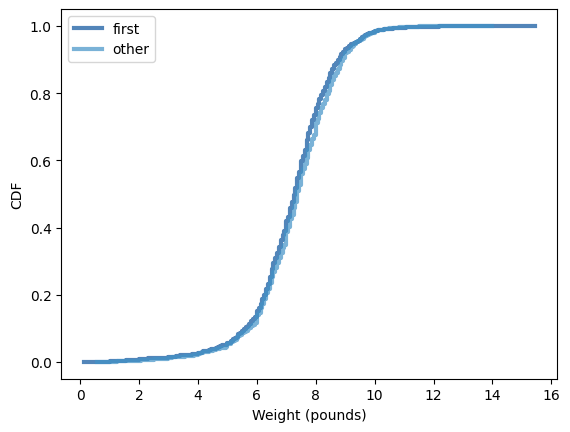

In [27]:
first_cdf = thinkstats2.Cdf(firsts.totalwgt_lb, label="first")
other_cdf = thinkstats2.Cdf(others.totalwgt_lb, label="other")

thinkplot.PrePlot(2)
thinkplot.Cdfs([first_cdf, other_cdf])
thinkplot.Config(xlabel="Weight (pounds)", ylabel="CDF")

##Percentile-Based Statistics

In [28]:
# We can use the CDF of birth weight to compute percentile-based statistics.
weights = live.totalwgt_lb
live_cdf = thinkstats2.Cdf(weights, label="live")

In [29]:
# Again, the median is the 50th percentile.
median = live_cdf.Percentile(50)
median

7.375

In [30]:
# The interquartile range is the interval from the 25th to 75th percentile.
iqr = (live_cdf.Percentile(25), live_cdf.Percentile(75))
iqr

(6.5, 8.125)

We can use the CDF to look up the percentile rank of a particular value.

For example, my second daughter was 10.2 pounds at birth, which is near the 99th percentile.

In [31]:
live_cdf.PercentileRank(10.2)

98.82717415357381

##Random Numbers

If we draw a random sample from the observed weights and map each weigh to its percentile rank.

In [37]:
sample = np.random.choice(weights, 100, replace=True)
rank = [live_cdf.PercentileRank(x) for x in sample]

The resulting list of ranks should be approximately uniform from 0-1.

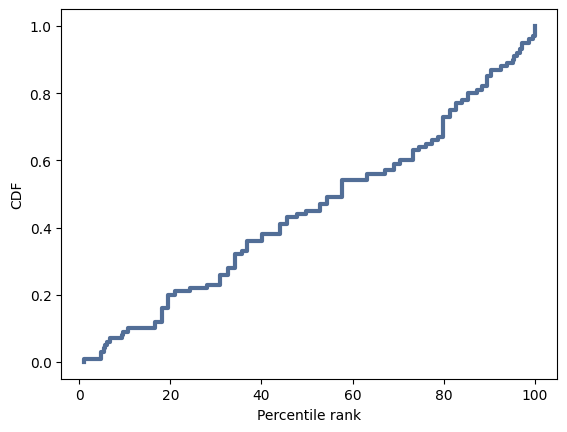

In [38]:
rank_cdf = thinkstats2.Cdf(rank)

thinkplot.Cdf(rank_cdf)
thinkplot.Config(xlabel="Percentile rank", ylabel="CDF")

The CDF is approximately a straight line, which means that
the distribution is uniform.

That observation is the basis of `Cdf.Sample`, which generates a random sample from a Cdf. Here's an example.

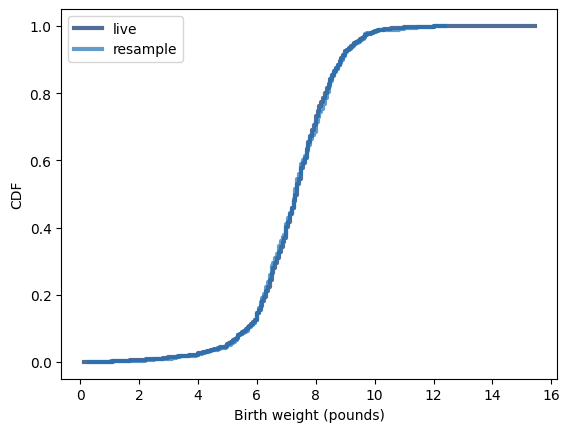

In [40]:
resample = live_cdf.Sample(1000)

thinkplot.Cdf(live_cdf)
thinkplot.Cdf(thinkstats2.Cdf(resample, label="resample"))
thinkplot.Config(xlabel="Birth weight (pounds)", ylabel="CDF")

This confirms that the random sample has the same distribution as the original data.

##Exercises